# PDE-constrained optimisation

We can build upon the automatic adjoint capabilities presented previously to solve problems of the following form:
$$
\operatorname{argmin}_{m\in M} \hat{J}(u(m), m)
$$
where $u(m) \in V$ is the (implicitly defined) solution operator for a weak form PDE satisfying:
$$
F(m, u; v) = 0 \qquad \forall v \in V
$$
As before, we represent $\hat{J}$ as a Firedrake `ReducedFunctional`.

The PDE constraint can comprise any number of PDEs. Formally this is equivalent to a single PDE over a suitably defined mixed solution space, but it is often expedient to solve multiple PDES separately in the model code. The Firedrake taping mechanism deals with this seemlessly.

In this case, we will examine a rather trivial optimisation example, but this will suffice to illustrate the solving process and the importance of the choice of inner product used in the optimsiation.

As usual, we import firedrake and set up solution plotting:

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
from firedrake import *
from firedrake.adjoint import *

In [3]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import tripcolor

def plot_fn(u):
    fig, axes = plt.subplots()
    collection = tripcolor(u, axes=axes)
    fig.colorbar(collection);

In order to illustrate the importance of inner product choice in optimisation, we will need a locally refined mesh. Here we use netgen's local refinement capabilities to produce a mesh with much finer resolution in it's central region than at the boundaries.

In [4]:
from netgen.geom2d import SplineGeometry

def refined_mesh(refinements: int=0):
    """A unit square mesh refined in the central region.

    Parameters
    ----------
    refinements:
        The number of times to refine the central portion of the mesh.
    """
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-1, -1),
                     p2=(1, 1),
                     bc="rectangle",
                     leftdomain=1,
                     rightdomain=0)

    mesh = Mesh(geo.GenerateMesh(maxh=0.1))

    def mark_centre(mesh):
        # Used to refine the center of mesh
        W = FunctionSpace(mesh, "DG", 0)
        mark = Function(W)
        x, y = SpatialCoordinate(mesh)
        centre = conditional( And((abs(x) < 0.4) , (abs(y) < 0.4)), 1.0, 0.0 )
        mark.interpolate(centre)
        return mark

    for i in range(refinements):
        mesh = mesh.refine_marked_elements(mark_centre(mesh))
    return mesh                                           

We'll plot the first three meshes in this sequence to get an idea of the refinement pattern.

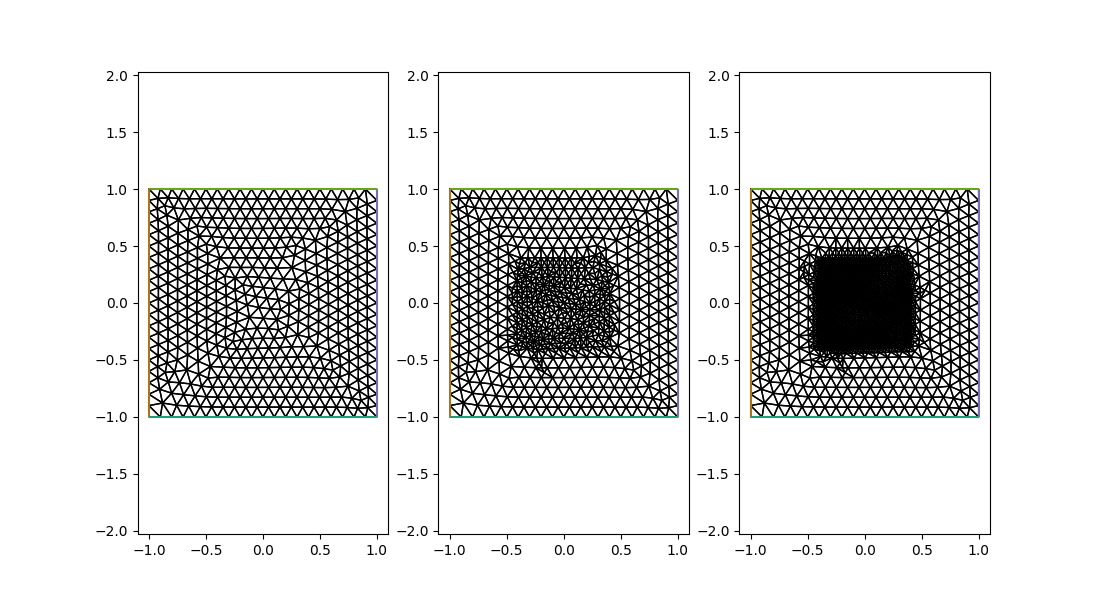

In [5]:
fig, axs = plt.subplots(1,3)
for i in range(3):
    mesh = refined_mesh(i)
    triplot(mesh, axes=axs[i])
    axs[i].set_aspect('equal', adjustable='datalim')


The PDE we'll consider is everyone's favourite, the Poisson equation. It's given in weak form as, given $m\in M\subset L^2(\Omega)$ and a suitable finite element space $V\subset H^1_0(\Omega)$ find $u\in V$ such that:
$$
F(m, u; v) = \int_\Omega \nabla u \cdot \nabla v - mv\,\mathrm{d}x = 0 \quad \forall v \in V.
$$

In [6]:
def solve_poisson(m):
    mesh = m.function_space().mesh()
    fs = FunctionSpace(mesh, "CG", 1)
    u = Function(fs)
    v = TestFunction(fs)
    bc = DirichletBC(fs, 0.0, "on_boundary")
    problem = NonlinearVariationalProblem(inner(grad(u), grad(v))*dx - m*v*dx, u, bc)
    solver = NonlinearVariationalSolver(problem)
    solver.solve()
    return u

The optimisation problem we consider is then:
$$
\operatorname{argmin}_{m\in M} \hat{J}(m) = J(u(m), m) = \frac{1}{2}\int_{\Omega} (u-d)^2 + \alpha m^2\,\mathrm{d}x
$$
where $d=\sin(\pi x)\sin(\pi y)/2 \pi$ and subject to:
$$
F(m, u; v) = 0 \quad \forall v \in V.
$$

Notice that we express $\hat{J}$ in Firedrake by creating a `ReducedFunctional` which depends on the `Control` `m`. In order that we can compute the correct gradient when required, we also indicate to the `Control` which Sobolev space (and hence which inner product to use).

In [7]:
def target(fs):
    x, y = SpatialCoordinate(fs.mesh())
    return assemble(interpolate(sin(pi*x)*sin(pi*y)/(2*pi), fs))


def record_poisson_functional(refinements=0, riesz_map="L2"):
    mesh = refined_mesh(refinements)
    fs = FunctionSpace(mesh, "CG", 1)
    m = Function(fs)  # Use a zero initial guess for the functional.
    tape = get_working_tape()
    tape.clear_tape()

    alpha = 1.e-6  # Control penalty.
    d = target(fs)
    continue_annotation()
    u = solve_poisson(m)
    J = assemble((u - d)**2/2*dx + alpha/2*m**2*dx) 
    pause_annotation()
    return ReducedFunctional(J, Control(m, riesz_map=riesz_map))

Let's try this out on the original, unrefined, mesh and treating $M$ as a subspace of $L^2$:

In [8]:
Jhat = record_poisson_functional(0, "L2")


As usual when employing the adjoint, it's a good idea to conduct a Taylor test to ensure that everything has been set up correctly. This requires two `Function`s from the same space as the control. We can access the control `Function` from within the `ReducedFunctional`.

In [9]:
m_ = Function(Jhat.controls[0].control)
h = Function(m_)
h.interpolate(1.0)
taylor_test(Jhat, m_, h)

Running Taylor test
Computed residuals: [5.4107846209969125e-06, 1.3526961552343417e-06, 3.3817403880786424e-07, 8.454350970138863e-08]
Computed convergence rates: [np.float64(2.0000000000158766), np.float64(2.000000000003077), np.float64(2.0000000000098535)]


np.float64(2.000000000003077)

Having defined the reduced functional, we now need to set up the optimisation. The pattern here is similar to that for solving variational problems: we set up a *problem* object containing the symbolic problem and then a *solver* object to configure the numerical algorithm.

In this case, the problem object is very simple, but `MinimizationProblem` can also encode bounds on controls and constraints on the functional value.

In [10]:
p = MinimizationProblem(Jhat)

There are a number of optimisation packages available to Firedrake. A good choice is often Tao, which is a part of the PETSc system and hence is installed by default in Firedrake. A `TaoSolver` takes a `MinimizationProblem` and a set of optimisation options in the PETSc options format that will be familiar from `NonLinearVariationalSolver`.

Here we choose the `lmvm` "limited memory variable metric" algorithm, which is the Tao implementation of the     Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorihm.

Switching on `tao_view` causes the configuration of the optimiser to be printed at the end of the computation, while `tao_monitor` causes the progress of the algorithm to be printed. Finally, `tao_converged_reason` causes the reason for convergence to be printed.

In [11]:
from pyadjoint.optimization.tao_solver import TAOSolver
solver = TAOSolver(p, {
    "tao_type": "lmvm",
    "tao_view": None,
    "tao_monitor": None,
    "tao_converged_reason": None,
    "tao_gatol": 1.0e-5,
    "tao_grtol": 0.0,
    "tao_gttol": 1.0e-5
})

The reduced functional remembers the last control value for which it was evaluated, and this is used as the initial guess in the optimisation algorithm. We reset the control value used to a zero function before solving:

In [12]:
Jhat(Function(Jhat.controls[0].control))
m_new = solver.solve()

  Iteration information for firedrake_3_ solve.
  0 TAO,  Function value: 0.0123473,  Residual: 0.00785893 
  1 TAO,  Function value: 0.00765569,  Residual: 0.00618756 
  2 TAO,  Function value: 5.21319e-06,  Residual: 0.000137438 
  3 TAO,  Function value: 5.12836e-06,  Residual: 0.000109449 
  4 TAO,  Function value: 4.98133e-06,  Residual: 5.11532e-06 
  TAO firedrake_3_ solve converged due to CONVERGED_GATOL iterations 4
Tao Object: (firedrake_3_) 1 MPI process
  type: lmvm
    Gradient steps: 0
    LMVM Matrix:
      Mat Object: (tao_lmvm_) 1 MPI process
        type: lmvmbfgs
        Max. storage: 5
        Used storage: 3
        Number of updates: 3
        Number of rejects: 0
        Number of resets: 1
        J0 KSP:
          KSP Object: (tao_lmvm_mat_lmvm_J0_) 1 MPI process
            type: preonly
            maximum iterations=1, initial guess is zero
            tolerances: relative=0., absolute=0., divergence=10000            left preconditioning
            using NO

We can now use the optimised control value found to compute a solution and to visualise the error in that solution.

In [17]:
u = solve_poisson(m_new)
error = assemble(interpolate(u - target(u.function_space()), u.function_space()))

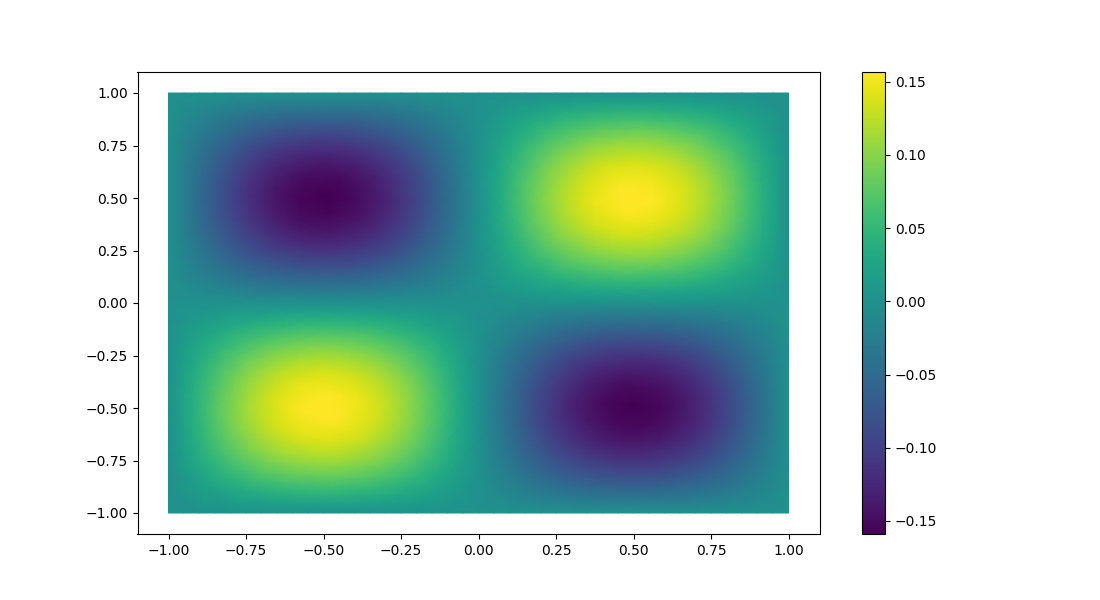

In [18]:
plot_fn(u)

In [20]:
pass

In order to facilitate experimentation, we'll now wrap up the optimisation process in a function:

In [21]:
def solve_optimisation(refinements=0, riesz_map="L2"):
    Jhat = record_poisson_functional(refinements, riesz_map)
    solver = TAOSolver(MinimizationProblem(Jhat), {
        "tao_type": "lmvm",
        "tao_converged_reason": None,
        "tao_gatol": 1.0e-5,
        "tao_grtol": 0.0,
        "tao_gttol": 1.0e-5
    })
    return solver.solve()

In [22]:
for i in range(4):
    solve_optimisation(refinements=i, riesz_map="L2")

  TAO firedrake_17_ solve converged due to CONVERGED_GATOL iterations 4
  TAO firedrake_30_ solve converged due to CONVERGED_GATOL iterations 4
  TAO firedrake_43_ solve converged due to CONVERGED_GATOL iterations 4
  TAO firedrake_56_ solve converged due to CONVERGED_GATOL iterations 4


In [23]:
for i in range(4):
    solve_optimisation(refinements=i, riesz_map="l2")

  TAO firedrake_69_ solve converged due to CONVERGED_GATOL iterations 466
  TAO firedrake_73_ solve did not converge due to DIVERGED_MAXITS iteration 2000


TAOConvergenceError: TAOSolver failed to converge after 2000 iterations with reason: DIVERGED_MAXITS